In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import palettable
from astropy import table
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coords
from astroquery.vizier import Vizier
import destroyer
plt.rc('figure', dpi=120)

In [2]:
t11 = Table.read("data/brewer2016/table11.dat", format='ascii.cds',
                 readme='data/brewer2016/ReadMe')
t9 = Table.read("data/brewer2016/table9.dat", format='ascii.cds',
                 readme='data/brewer2016/ReadMe')
t8 = Table.read("data/brewer2016/table8.dat", format='ascii.cds',
                 readme='data/brewer2016/ReadMe')

In [13]:
ra = ((np.array(t11['RAh'])
      + np.array(t11['RAm'])/60.
      + np.array(t11['RAs'])/3600.)*u.hourangle).to(u.deg)
dec = np.array([s+'1' for s in t11['DE-']]).astype(np.int) *\
    (np.array(t11['DEd'])*u.deg
     + np.array(t11['DEm'])*u.arcmin
     + np.array(t11['DEs'])*u.arcsec).to(u.deg)

In [15]:
len(t11), np.unique(t11['SPOCS']).size, np.unique(t11['Name']).size

(1615, 1615, 1615)

In [16]:
coords_brewer = coords.SkyCoord(ra, dec)

In [17]:
idx_self, angsep_self, sep3d_self = coords_brewer.match_to_catalog_sky(coords_brewer, nthneighbor=2)

In [18]:
match_self = angsep_self<2*u.arcsec
for i, j, sep in zip(np.where(match_self)[0], idx_self[match_self], angsep_self[match_self].to(u.arcsec)):
    print("{:4d} {:4d} {:6.2f}".format(i, j, sep))

 539  540   1.13 arcsec
 540  539   1.13 arcsec
 670  670   0.00 arcsec
 772  772   0.00 arcsec
 813 1487   0.00 arcsec
1429  670   0.00 arcsec
1471  772   0.00 arcsec
1487 1487   0.00 arcsec


In [31]:
# three pairs with exactly the same RA, Dec
print(t11[[539, 540, 670, 1429, 772, 1471, 813,1487]]['SPOCS', 'Name', 'RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs'])

SPOCS     Name    RAh RAm RAs  DE- DEd  DEm    DEs  
                   h  min  s       deg arcmin arcsec
----- ----------- --- --- ---- --- --- ------ ------
 2163   KOI-284 W  18  52 55.8   +  41     20     29
 2164   KOI-284 E  18  52 55.9   +  41     20     29
 2296  HTR115-003  19  24 39.0   +  55     28     23
 3062     WASP-48  19  24 39.0   +  55     28     23
 2400 KIC-8311864  19  44  0.9   +  44     16     39
 3104    KOI-7016  19  44  0.9   +  44     16     39
 2441 KIC-6307537  19  51  1.7   +  41     40     50
 3120    KOI-1120  19  51  1.7   +  41     40     50


In [32]:
idx_clear = np.where(~match_self)[0]
print("number of unambiguous stars = {:d}".format(idx_clear.size))

number of unambiguous stars = 1607


In [36]:
brewer = pd.merge(t8[idx_clear].to_pandas(), t9[idx_clear].to_pandas())
brewer['ra'] = ra.value[idx_clear]
brewer['dec'] = dec.value[idx_clear]

In [34]:
lamost = destroyer.data.load_lamost()
lookup = destroyer.data.load_lookup()

In [37]:
coords_lamost = coords.SkyCoord(lamost['ra']*u.deg, lamost['dec']*u.deg)
coords_brewer = coords.SkyCoord(brewer.ra.values*u.deg, brewer.dec.values*u.deg)

In [38]:
idx, sep2d, sep3d = coords_brewer.match_to_catalog_sky(coords_lamost)

In [39]:
np.sum(sep2d.to(u.arcsec).value<2)

158

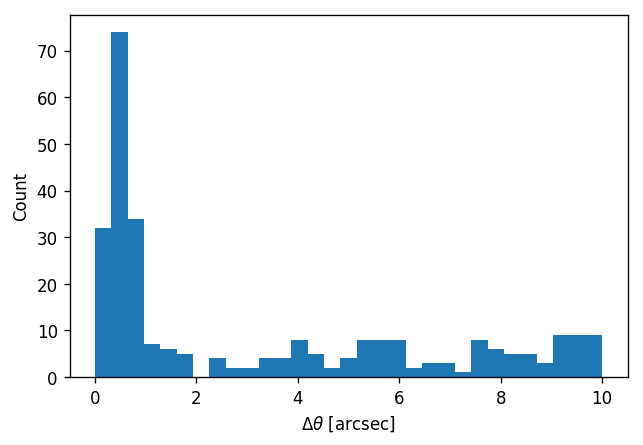

In [40]:
plt.hist(sep2d.to(u.arcsec).value, np.linspace(0,10,32));
plt.xlabel(r"$\Delta \theta$ [arcsec]");
plt.ylabel('Count');

In [41]:
match = sep2d < 1*u.arcsec
print('number of matches = {:d}'.format(match.sum()))

number of matches = 142


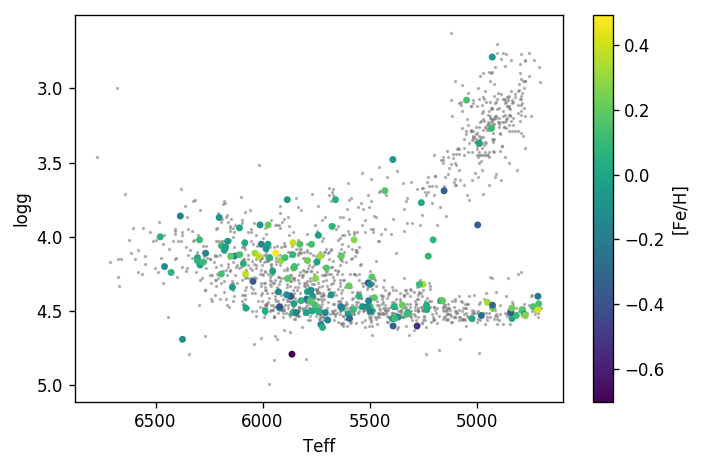

In [43]:
plt.scatter(brewer['Teff'], brewer['logg'], s=1, c='tab:gray', alpha=.5)
plt.scatter(brewer['Teff'][match], brewer['logg'][match], s=10,
            c=brewer['[Fe/H]'][match]);
plt.gca().invert_xaxis();
plt.gca().invert_yaxis();
plt.colorbar(label='[Fe/H]');
plt.xlabel("Teff");
plt.ylabel("logg");
plt.tight_layout();
plt.savefig("plots/lamost_brewerx_params.png")

0.10938282319016866


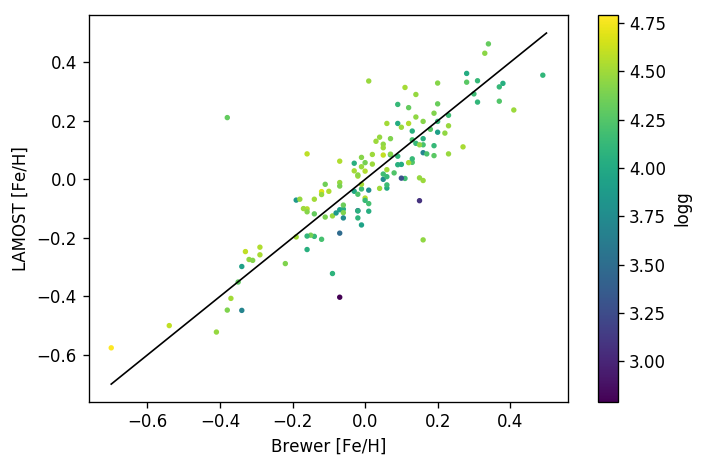

In [44]:
plt.scatter(brewer['[Fe/H]'][match], lamost['feh'][idx[match]], c=brewer['logg'][match], s=5);
plt.colorbar(label='logg');
plt.xlabel("Brewer [Fe/H]")
plt.ylabel("LAMOST [Fe/H]")
x = np.linspace(-0.7,0.5)
plt.plot(x, x, c='k', lw=1);

# plt.scatter(ds.tr_label[:,2] , ds.test_label_vals[:,2], s=5, c='k')
plt.tight_layout()
# plt.savefig('plots/FeH_lamost_brewer.png');
print(np.std(brewer['[Fe/H]'][match]-lamost['feh'][idx[match]]))
# print(np.std(ds.tr_label[:,2]-ds.test_label_vals[:,2]))


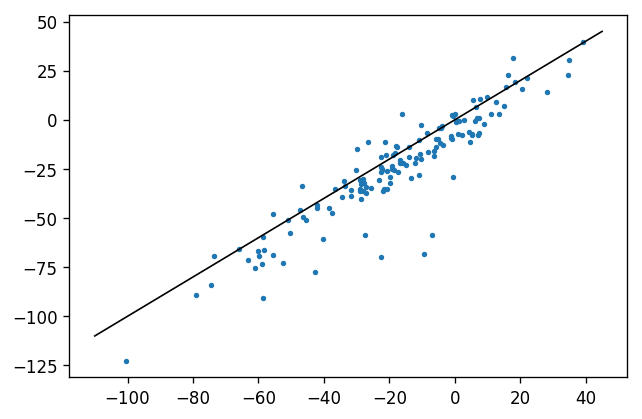

In [45]:
plt.scatter(brewer['Vrad'][match], lamost['rv'][idx[match]], s=5)
x = np.linspace(-110,45)
plt.plot(x, x, 'k-', lw=1);

In [156]:
abundance_columns = ['__C_H_',
 '__N_H_',
 '__O_H_',
 '__Na_H_',
 '__Mg_H_',
 '__Al_H_',
 '__Si_H_',
 '__Ca_H_',
 '__Ti_H_',
 '__V_H_',
 '__Cr_H_',
 '__Mn_H_',
 '__Fe_H_',
 '__Ni_H_',
 '__Y_H_',]

In [157]:
df_abun = brewer[abundance_columns].to_pandas()

In [158]:
for col in df_abun.columns:
    df_abun[col.split('_')[2]+'/Fe'] = df_abun[col] - df_abun['__Fe_H_']

In [159]:
XFe_columns = ['C/Fe', 'N/Fe', 'O/Fe', 'Na/Fe', 'Mg/Fe', 'Al/Fe', 'Si/Fe',
               'Ca/Fe', 'Ti/Fe', 'V/Fe', 'Cr/Fe', 'Mn/Fe', 'Ni/Fe', 'Y/Fe']

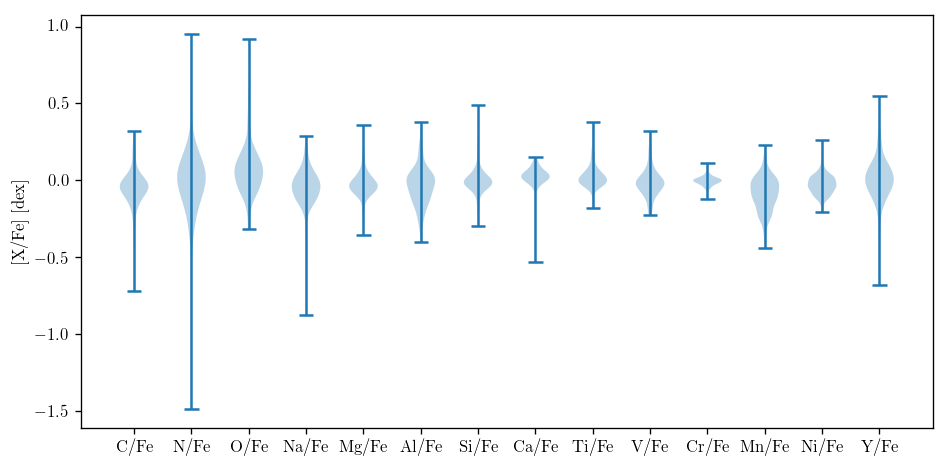

In [160]:
plt.figure(figsize=(8,4))
# plt.plot(df_abun.loc[match, XFe_columns].values.T, c='k', lw=1, alpha=.2);
data_dropna = [v.dropna().values for k,v in df_abun.loc[match, XFe_columns].items()]
plt.violinplot(data_dropna,
               positions=np.arange(0, len(XFe_columns)));
plt.xticks(np.arange(0, len(XFe_columns)), XFe_columns);
plt.ylabel('[X/Fe] [dex]',);
plt.tight_layout()
plt.savefig('plots/brewerx_abundance_ranges.png')

In [48]:
d = destroyer.Spectra.from_npz("data/lamost_brewerx_spectra.npz")

Trashing 2 spectra: weird constant flux spectra


In [56]:
df_brewerx = brewer.iloc[match].copy().reset_index()
df_lamostx = pd.DataFrame(lamost[idx[match]].byteswap().newbyteorder())
df_lamostx['filename'] = lookup[idx[match]]

df_xmerged = pd.merge(df_brewerx, df_lamostx, left_index=True, right_index=True,
         suffixes=('_brewer', '_lamost'))

In [58]:
df_spec = pd.DataFrame({'filename':d.filenames, 'specidx':np.arange(d.filenames.size)})
df_xmerged = pd.merge(df_xmerged, df_spec)

In [59]:
len(df_xmerged)

140

In [62]:
set(np.arange(142)) - set(df_xmerged.index.values)

{140, 141}

In [63]:
from TheCannon import model, dataset

In [65]:
tr_labels = df_xmerged[['Teff', 'logg_brewer', '[Fe/H]']].values

In [66]:
ivar = d.ivar[df_xmerged['specidx'].values]
ivar[d.mask[df_xmerged['specidx'].values]] = 0.

flux = d.flux[df_xmerged['specidx'].values]
flux[d.mask[df_xmerged['specidx'].values]] = 1.

In [67]:
ds = dataset.Dataset(
    d.wave, d.idx[df_xmerged['specidx'].values], flux, ivar, tr_labels,
    d.idx[df_xmerged['specidx'].values], flux, ivar)

Loading dataset
This may take a while...


In [68]:
ds.set_label_names(['teff','logg','feh'])

In [72]:
%%time
m = model.CannonModel(2, useErrors=False)
m.fit(ds)

Done training model. 
CPU times: user 7.3 s, sys: 180 ms, total: 7.48 s
Wall time: 8.06 s


In [74]:
m.coeffs.shape

(3594, 10)

In [83]:
m.infer_labels(ds)
m.infer_spectra(ds)

Inferring Labels


In [96]:
ds.diagnostics_1to1()

Diagnostic for label output vs. input
Saved fig 1to1_label_0.png
Diagnostic for label output vs. input
Saved fig 1to1_label_1.png
Diagnostic for label output vs. input
Saved fig 1to1_label_2.png


In [102]:
m.model_spectra.shape

(140, 3594)

In [279]:
print("brewer {:7.2f} {:7.3f} {:7.3f}".format(*ds.tr_label[i]))
print("lamost {:7.2f} {:7.3f} {:7.3f}".format(*df_xmerged.loc[i, ['teff','logg_lamost','feh']].values))
print("cannon {:7.2f} {:7.3f} {:7.3f}".format(*ds.test_label_vals[i]))

brewer 5919.00   4.480  -0.090
lamost 5927.32   4.422  -0.125
cannon 5912.64   4.332  -0.192


In [278]:
m.pivots

array([5.740e+03, 4.325e+00, 2.500e-02])

In [270]:
df_xmerged.iloc[i]

index                                                     497
SPOCS                                                    2121
Name                                               HTR285-001
Teff                                                     5916
logg_brewer                                              4.16
[M/H]                                                    0.28
S                                                        0.14
logRhk                                                  -5.11
Vbr                                                       5.6
Vsini                                                     3.5
Vmac                                                      4.2
Vrad                                                      -61
SNR                                                       152
Crms                                                     0.01
Lrms                                                     0.01
N                                                           1
[C/H]   

In [130]:
gs = destroyer.data.GradientSpectra()

array([-0.00173977, -0.00044904, -0.00024538, ...,  0.00022301,
        0.0002028 ,  0.00012631])

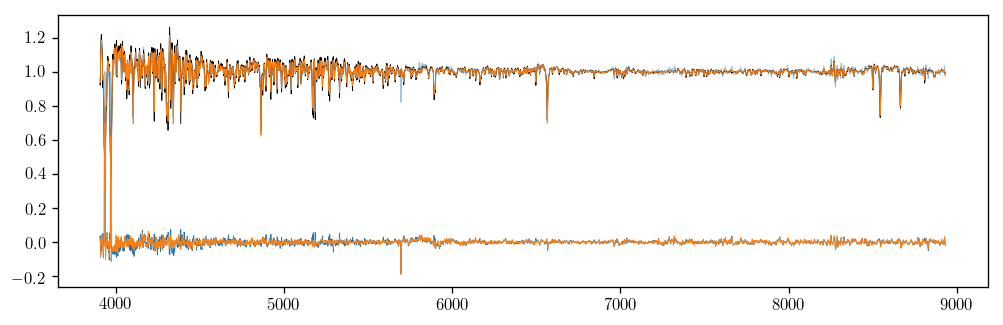

In [277]:
plt.figure(figsize=(10,3))
i=12
plt.plot(ds.wl, ds.tr_flux[i], c='tab:blue', alpha=0.5, lw=0.5);
plt.plot(ds.wl, m.coeffs[:,0], lw=.5, c='k');
plt.plot(ds.wl, ds.tr_flux[i] - m.coeffs[:,0], lw=.5);
plt.plot(ds.wl, m.model_spectra[i], c='tab:orange', lw=.5);
plt.plot(ds.wl, ds.tr_flux[i] - m.model_spectra[i], lw=.5,);
# plt.plot(ds.wl, m.model_spectra[i]-m.coeffs[:,0], lw=.5);
# plt.plot(gs.wave, gs.gradient[20].T, lw=1, c='k');
# plt.xlim(5500, 6000);
# plt.ylim(-0.25,0.25)

Diagnostic plot: leading coeffs and scatters across wavelength.


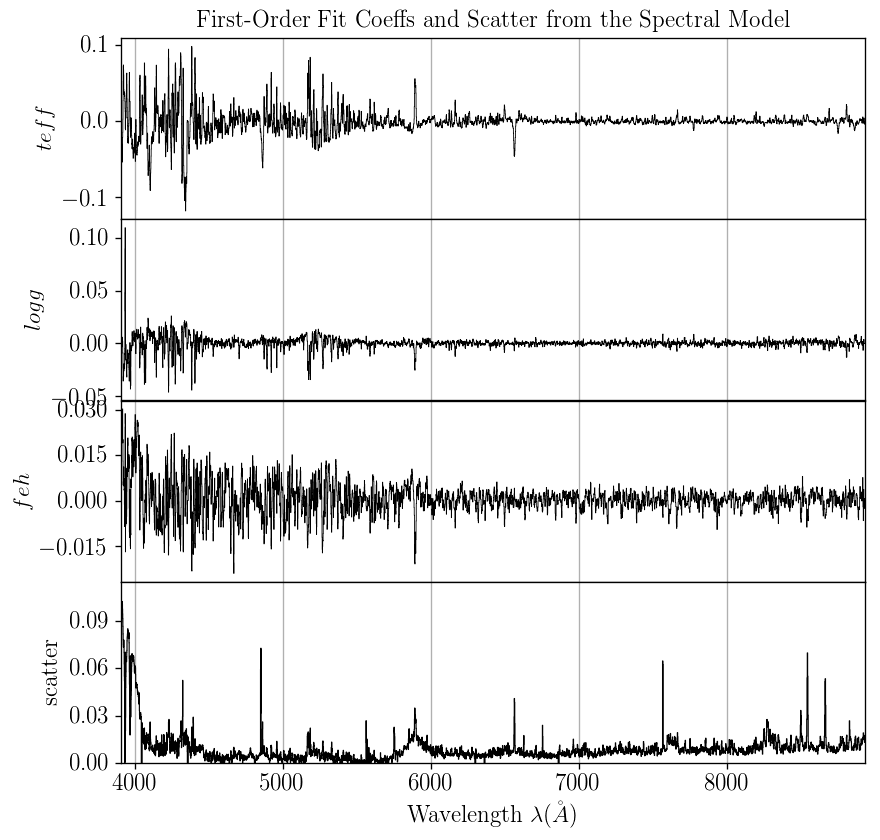

In [73]:
m.diagnostics_leading_coeffs(ds);

In [120]:
m.predict(ds)

Inferring Labels


(array([[0.01216913, 0.02677974, 0.03237938],
        [0.02458044, 0.06610331, 0.03517933],
        [0.03653293, 0.12052421, 0.09925631],
        [0.02234225, 0.05011667, 0.03313761],
        [0.0424901 , 0.0770729 , 0.12226038],
        [0.00936006, 0.01853494, 0.01927344],
        [0.0356957 , 0.09115992, 0.06576883],
        [0.02848963, 0.07139718, 0.03759553],
        [0.01997023, 0.04457077, 0.05389813],
        [0.0113847 , 0.02359994, 0.02222184],
        [0.01565474, 0.03983647, 0.03602652],
        [0.01282457, 0.02311488, 0.03200909],
        [0.03360127, 0.06860332, 0.06159735],
        [0.0250634 , 0.04286996, 0.05940659],
        [0.01428328, 0.0314741 , 0.02976738],
        [0.01563323, 0.02844608, 0.03692477],
        [0.04087401, 0.07769119, 0.08256249],
        [0.01471422, 0.0267856 , 0.04031715],
        [0.00943491, 0.01789521, 0.02281915],
        [0.08432587, 0.15160643, 0.24693072],
        [0.01422394, 0.03472372, 0.01739916],
        [0.07107111, 0.17760613, 0

In [139]:
m.infer_spectra(ds)

In [146]:
df_merged.iloc[0]

d_idx                                                        0
filename        spec-57527-HD190719N431855V01_sp14-013.fits.gz
index                                                       44
SPOCS                                                     2997
Name                                              b'Kepler-37'
Teff                                                      5391
logg_x                                                     4.6
__M_H_                                                   -0.31
S                                                         0.18
logRhk                                                   -4.94
Vbr                                                        2.7
Vsini                                                      0.9
Vmac                                                       2.4
Vrad                                                     -31.6
SNR                                                        251
Crms                                                   

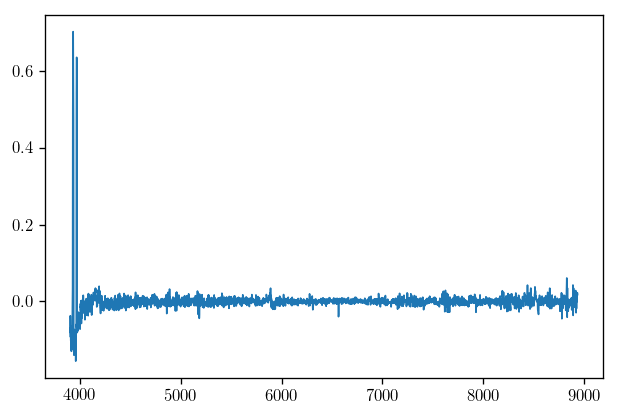

In [147]:
plt.plot(ds.wl, ds.test_flux[1] - m.model_spectra[1], lw=1);